# Optimization Benchmark: Overlapping Genes Algorithm

Comparing the performance of the original vs optimized implementations.

**Key Optimization:**
- Original: Recalculates full O(L²) energy after every mutation
- Optimized: Uses O(L) delta energy calculation + Numba JIT compilation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import json

import overlappingGenes as optimized
import overlappingGenesoriginal as original

print("Modules imported successfully")

Modules imported successfully


## Load Parameters and Temperatures

In [2]:
# Load optimal temperatures
with open('optimal_temperatures.json', 'r') as f:
    optimal_temps = json.load(f)

# Protein families to use
pf1, pf2 = 'PF00004', 'PF00041'
T1 = optimal_temps[pf1]
T2 = optimal_temps[pf2]

print(f"Temperatures: T1 ({pf1}) = {T1:.4f}, T2 ({pf2}) = {T2:.4f}")

# Load DCA parameters
Js_1, hs_1 = optimized.extract_params(f"{pf1}/{pf1}_params.dat")
Js_2, hs_2 = optimized.extract_params(f"{pf2}/{pf2}_params.dat")

DCA_params_1 = [Js_1, hs_1]
DCA_params_2 = [Js_2, hs_2]

# Protein lengths
lenprot1 = len(hs_1) / 21
lenprot2 = len(hs_2) / 21

# Natural energies for reference lines
naturalenergies1 = optimized.load_natural_energies(f"{pf1}/{pf1}_naturalenergies.txt")
naturalenergies2 = optimized.load_natural_energies(f"{pf2}/{pf2}_naturalenergies.txt")
mean_1, std_1 = np.mean(naturalenergies1), np.std(naturalenergies1)
mean_2, std_2 = np.mean(naturalenergies2), np.std(naturalenergies2)

print(f"Protein 1 ({pf1}): {int(lenprot1)} aa, natural E = {mean_1:.1f} ± {std_1:.1f}")
print(f"Protein 2 ({pf2}): {int(lenprot2)} aa, natural E = {mean_2:.1f} ± {std_2:.1f}")

Temperatures: T1 (PF00004) = 0.8667, T2 (PF00041) = 1.0000
Protein 1 (PF00004): 110 aa, natural E = 145.9 ± 38.2
Protein 2 (PF00041): 74 aa, natural E = 120.7 ± 17.6


## Setup and JIT Warmup

In [3]:
# Parameters
overlapLen = 62
num_iterations = 50000
whentosave = 0.02  # 50 data points

# Generate shared initial sequence
np.random.seed(42)
initial_seq = optimized.initial_seq_no_stops(lenprot1, lenprot2, overlapLen, quiet=True)

print(f"Overlap: {overlapLen} nt, Iterations: {num_iterations:,}")

# JIT warmup
print("Warming up JIT...")
_ = optimized.overlapped_sequence_generator_int(
    DCA_params_1, DCA_params_2, initial_seq,
    T1=T1, T2=T2, numberofiterations=100, quiet=True, whentosave=0.5
)
_ = original.overlapped_sequence_generator_int(
    DCA_params_1, DCA_params_2, initial_seq,
    T1=T1, T2=T2, numberofiterations=100, quiet=True, whentosave=0.5
)
print("Ready!")

Overlap: 62 nt, Iterations: 50,000
Warming up JIT...
Ready!


## Run Benchmark

In [4]:
# Run original
print("Running ORIGINAL (O(L²) per iteration)...")
start = time.time()
result_orig = original.overlapped_sequence_generator_int(
    DCA_params_1, DCA_params_2, initial_seq,
    T1=T1, T2=T2, numberofiterations=num_iterations, quiet=True, whentosave=whentosave
)
time_orig = time.time() - start
_, _, E1_hist_orig, E2_hist_orig, _ = result_orig
print(f"  Done: {time_orig:.2f}s")

# Run optimized
print("Running OPTIMIZED (O(L) delta + JIT)...")
start = time.time()
result_opt = optimized.overlapped_sequence_generator_int(
    DCA_params_1, DCA_params_2, initial_seq,
    T1=T1, T2=T2, numberofiterations=num_iterations, quiet=True, whentosave=whentosave
)
time_opt = time.time() - start
_, _, E1_hist_opt, E2_hist_opt, _, _, _ = result_opt
print(f"  Done: {time_opt:.2f}s")

speedup = time_orig / time_opt
print(f"\nSpeedup: {speedup:.1f}x")

Running ORIGINAL (O(L²) per iteration)...
  Done: 9.50s
Running OPTIMIZED (O(L) delta + JIT)...
  Done: 0.20s

Speedup: 48.2x


## Convergence Curves (Energy vs Wall Time)

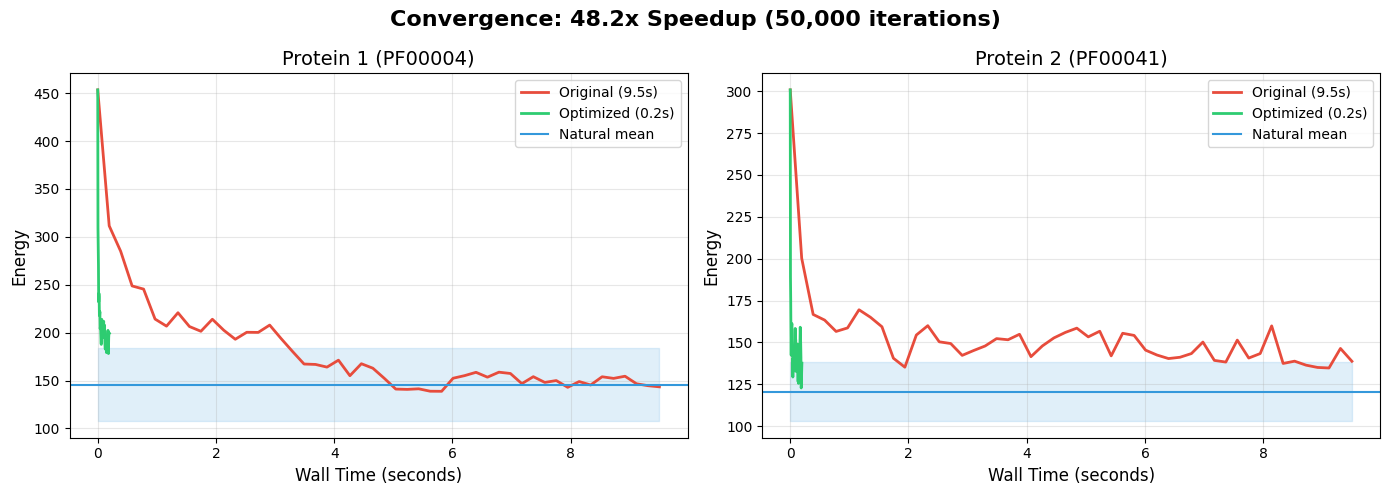

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

time_points_orig = np.linspace(0, time_orig, len(E1_hist_orig))
time_points_opt = np.linspace(0, time_opt, len(E1_hist_opt))

color_orig = '#e74c3c'
color_opt = '#2ecc71'
color_nat = '#3498db'

# Protein 1
ax = axes[0]
ax.plot(time_points_orig, E1_hist_orig, '-', color=color_orig, lw=2, label=f'Original ({time_orig:.1f}s)')
ax.plot(time_points_opt, E1_hist_opt, '-', color=color_opt, lw=2, label=f'Optimized ({time_opt:.1f}s)')
ax.axhline(y=mean_1, ls='-', color=color_nat, lw=1.5, label='Natural mean')
ax.fill_between([0, max(time_orig, time_opt)], mean_1 - std_1, mean_1 + std_1, color=color_nat, alpha=0.15)
ax.set_xlabel('Wall Time (seconds)', fontsize=12)
ax.set_ylabel('Energy', fontsize=12)
ax.set_title(f'Protein 1 ({pf1})', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Protein 2
ax = axes[1]
ax.plot(time_points_orig, E2_hist_orig, '-', color=color_orig, lw=2, label=f'Original ({time_orig:.1f}s)')
ax.plot(time_points_opt, E2_hist_opt, '-', color=color_opt, lw=2, label=f'Optimized ({time_opt:.1f}s)')
ax.axhline(y=mean_2, ls='-', color=color_nat, lw=1.5, label='Natural mean')
ax.fill_between([0, max(time_orig, time_opt)], mean_2 - std_2, mean_2 + std_2, color=color_nat, alpha=0.15)
ax.set_xlabel('Wall Time (seconds)', fontsize=12)
ax.set_ylabel('Energy', fontsize=12)
ax.set_title(f'Protein 2 ({pf2})', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle(f'Convergence: {speedup:.1f}x Speedup ({num_iterations:,} iterations)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('optimization_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

## Scaling Analysis

In [6]:
iteration_counts = [1000, 5000, 10000, 25000, 50000]
times_orig, times_opt = [], []

print("Running scaling analysis...")
for n in iteration_counts:
    # Original
    start = time.time()
    _ = original.overlapped_sequence_generator_int(
        DCA_params_1, DCA_params_2, initial_seq,
        T1=T1, T2=T2, numberofiterations=n, quiet=True, whentosave=0.5
    )
    times_orig.append(time.time() - start)
    
    # Optimized
    start = time.time()
    _ = optimized.overlapped_sequence_generator_int(
        DCA_params_1, DCA_params_2, initial_seq,
        T1=T1, T2=T2, numberofiterations=n, quiet=True, whentosave=0.5
    )
    times_opt.append(time.time() - start)
    
    print(f"  {n:,}: orig={times_orig[-1]:.2f}s, opt={times_opt[-1]:.2f}s, speedup={times_orig[-1]/times_opt[-1]:.1f}x")

speedups = [to/tp for to, tp in zip(times_orig, times_opt)]

Running scaling analysis...
  1,000: orig=0.17s, opt=0.01s, speedup=33.2x
  5,000: orig=1.36s, opt=0.02s, speedup=72.6x
  10,000: orig=1.89s, opt=0.04s, speedup=45.4x
  25,000: orig=5.11s, opt=0.07s, speedup=71.4x
  50,000: orig=8.93s, opt=0.18s, speedup=48.8x


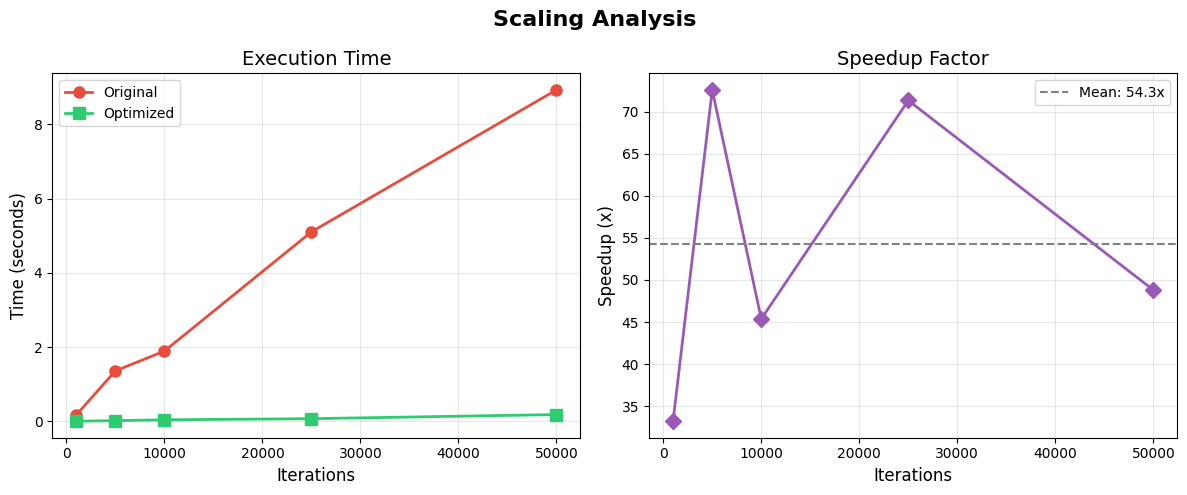


Average speedup: 54.3x


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Time comparison
ax = axes[0]
ax.plot(iteration_counts, times_orig, 'o-', color=color_orig, lw=2, ms=8, label='Original')
ax.plot(iteration_counts, times_opt, 's-', color=color_opt, lw=2, ms=8, label='Optimized')
ax.set_xlabel('Iterations', fontsize=12)
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('Execution Time', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Speedup
ax = axes[1]
ax.plot(iteration_counts, speedups, 'D-', color='#9b59b6', lw=2, ms=8)
ax.axhline(y=np.mean(speedups), ls='--', color='gray', label=f'Mean: {np.mean(speedups):.1f}x')
ax.set_xlabel('Iterations', fontsize=12)
ax.set_ylabel('Speedup (x)', fontsize=12)
ax.set_title('Speedup Factor', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Scaling Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('scaling_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAverage speedup: {np.mean(speedups):.1f}x")

## Summary

The optimized implementation achieves speedup through:

1. **O(L) Delta Energy**: Only compute energy change from the mutated amino acid, not full O(L²) recalculation
2. **Numba JIT**: Core loop compiled to machine code
3. **Pre-allocated buffers**: No per-iteration memory allocation
4. **Integer encoding**: Nucleotides as ints (0-3) for faster operations